In [27]:
import pyBigWig
import numpy as np

In [28]:
#файл с треком генома человека сборка 38
track_file = "/Users/pochtalionizm/Projects/neuro/data/hg38.phastCons20way.bw"

In [29]:
bw = pyBigWig.open(track_file)
bw.chroms()
bw.chroms("chr2")

242193529

In [30]:
#загрузка нужных результатов предсказания
path = "/Users/pochtalionizm/Projects/neuro/results/2019-02-24_18:08:04_2.5-2.7_NC_000002.12_Homo"
seq_np = np.load(path + "/seq_np.npy")
mask = np.load(path + "/mask.npy")
out_np = np.load(path + "/04000_out_np.npy")
info = open(path + "/info.txt")
print(info.readlines())
info.close()

['2019-02-24_18:08:04\n', 'skip_depth6,reflection,net,adam,noise,32,0.01,0.03,4001,True,646788\n', '0500000_006000000_2.5-2.7_47561_NC_000002.12_Homo_sapiens_chromosome_2,_GRCh38.p12_Primary_Assembly\n']


In [31]:
#выбор нужной части генома 
track_part = bw.values("chr2", 6000000, 6500000, numpy = True)
len(track_part)

500000

In [32]:
#функция сравнения
def compare(seq_np, out_np):
    if len(seq_np) != len(out_np):
        print("error")
        return None
    
    length = len(seq_np[0])

    out_array = np.zeros((4,length)) #array analog to seq_np
    for i in range(length):
        n = np.argmax(out_np[:, i])
        out_array[n, i] = 1
            
    diff = np.zeros(length)
    for i in range(length):
        a = out_array[:, i]
        b = seq_np[:, i]
        diff[i] = np.linalg.norm(a-b)
    return diff

In [33]:
#возвращает массив расстояний между исходником и предсказанием
diff = compare(seq_np, out_np)

In [34]:
print("seq length", len(diff))
print("mistakes", sum([1 for x in diff if x > 0.01]))

seq length 500000
mistakes 346624


In [40]:
#выбираем часть под маской
mask_diff = []
mask_track_part = []
free_diff = []
free_track_part = []
for i in range(len(diff)):
    if not (isinstance(diff[i], float) or isinstance(track_part[i], float)):
        print("None")
        
    if mask[i]==1:
        mask_diff.append(diff[i])
        mask_track_part.append(track_part[i])
    else:
        free_diff.append(diff[i])
        free_track_part.append(track_part[i])

print(len(mask_diff) + len(free_diff))
print(len(free_track_part) + len(mask_track_part))

500000
500000


In [48]:
max(free_diff)

1.4142135623730951

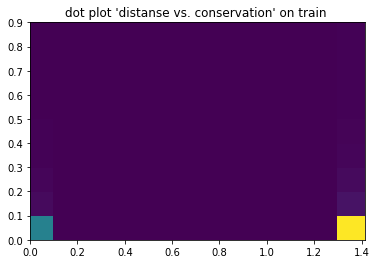

In [72]:
import matplotlib.pyplot as plt
# plt.plot(free_diff, free_track_part, "r,")
plt.hist2d(free_diff, free_track_part, bins = [[0, 0.1, 1.3, max(free_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on train ")
# plt.xlabel("distance")
# plt.ylabel("value of conservation")
# plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_1.png")

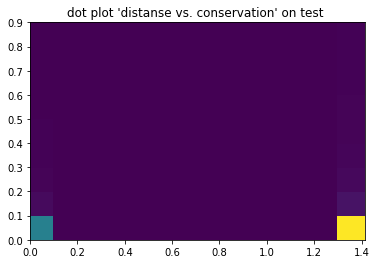

In [73]:
import matplotlib.pyplot as plt
# plt.plot(mask_diff, mask_track_part, "r,")
plt.hist2d(mask_diff, mask_track_part, bins = [[0, 0.1, 1.3, max(mask_diff)], np.arange(0, 1, 0.1)])
plt.title("dot plot 'distanse vs. conservation' on test ")
# plt.xlabel("distance")
# plt.ylabel("value of conservation")
# plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/hist2d_2.png")

14484
47561


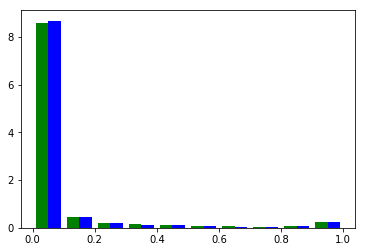

In [58]:
track_mask_for_small_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-0.0<0.1 ]
track_mask_for_big_d = [mask_track_part[i] for i in range(len(mask_diff)) if mask_diff[i]-1.4<0.1 ]
print(len(track_mask_for_small_d ))
print(len(track_mask_for_big_d))
plt.hist([track_mask_for_small_d , track_mask_for_big_d ], color = ['green', 'blue'], density = True)
plt.title("")
plt.show()

138892
452439


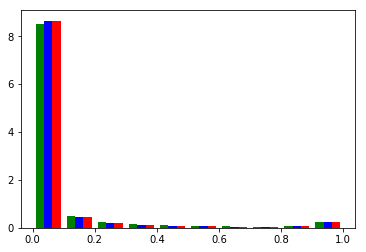

In [63]:
track_free_for_small_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-0.0<0.1 ]
track_free_for_big_d = [free_track_part[i] for i in range(len(free_track_part)) if free_diff[i]-1.4<0.1 ]
print(len(track_free_for_small_d))
print(len(track_free_for_big_d))
plt.hist([track_free_for_small_d, track_free_for_big_d, track_part], color = ['green', 'blue', "red"], density = True)
plt.show()

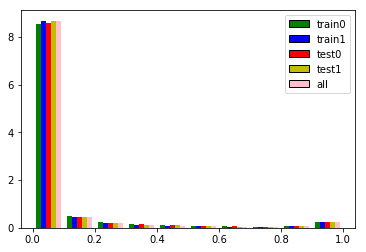

In [75]:
from matplotlib.patches import Rectangle
c = ['g', 'b', 'r', 'y' , 'pink']
plt.hist([track_free_for_small_d, track_free_for_big_d, track_mask_for_small_d, 
          track_mask_for_big_d, track_part], 
         color = c, density = True)

handles = [Rectangle((0,0),1,1,color=col,ec="k") for col in c]
labels= ['train0','train1','test0', 'test1', 'all' ]
plt.legend(handles, labels)
plt.show()
# plt.savefig("/Users/pochtalionizm/Projects/neuro/results/3/all_cons.png")